# Frontier Production Function

A frontier production function is a method of economic analysis used to asses the use efficiency of a limited number of resources in industry. Perhaps, the most traditional example involves the analysis of resources such as labor and capital required to produce a specic good. The concept has also been widely applied in agriculture to assess the regional (e.g. county, shire) or farm production efficiency as a function of growing season water supply. 

In this exercise you will learn how to fit a frontier production function using a dataset of winter wheat grain yield and growing season precipitation for Grant county in Oklahoma. We will implement the Cobb-Douglas model, which is one of the most common models. If you are interested in this topic you should read the seminal paper by Cobb and Douglas published in 1928.

$$ y = a + b \ ln(x) + c \ [ln(x)]^2 \ , \quad x>0 $$

In [1]:
# Import modules
import glob
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit, newton
import matplotlib.pyplot as plt

np.seterr(divide = 'ignore'); # Suppress warning about diving by zero


In [2]:
# Load yield and precipitation data
data = pd.read_csv("../datasets/frontier_yield_rainfall.csv", header=1)
data.head()


,year,county,grain_yield,rainfall
0,1919,GRANT,1021.596244,602.107
1,1920,GRANT,1122.411663,477.647
2,1922,GRANT,678.823820,389.128
3,1923,GRANT,860.291574,591.185
4,1924,GRANT,1021.596244,516.001


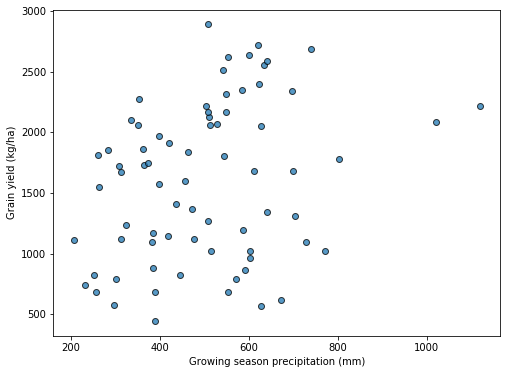

In [5]:
# Explore data
plt.figure(figsize=(8,6))
plt.scatter(data["rainfall"], data["grain_yield"], edgecolor='k', alpha=0.75)
plt.xlabel('Growing season precipitation (mm)')
plt.ylabel('Grain yield (kg/ha)')
plt.show()


Our next step is to partition the dataset into continuous and non-overlapping rainfall intervals that we will call bins, similar to histogram bins.

To generate the bins we will search for the minimum and maximum values of the rainfall vector and then use this information to generate linearly spaced (it could also be log-spaced) rainfall values that we will use to partion the dataset at regular intervals. In other words, each bin will be defined by a lower and upper rainfall boundary.

THen, the idea is to select the highest observed grain yield obtained within a specific bin. We will also need to identify the position of the highest yield observation for that specific bin because we also need to retrive the growing season rainfall at which the highest yield was achieved. The highest yield and its corresponding rainfall within a bin represent a pair of `x,y` coordinates that we can use to approximate the frontier function. Of course we will collect several of these pairs, as many as `N-1`, where `N` denotes the number of bins.

As usual, we need to consider potentially missing values (represented as NaN) or perhaps rainfall bins that do not contain any yield data. The latter situation could arise from a dataset with insufficient yield observations in certain rainfall ranges or a as a result of dividing the dataset into a large number of bins, and therefore, so narrow that there might not be any historical yield record for that specific narrow bin.


In [6]:
# Identify boundary points
max_rainfall = np.max(data.rainfall)
min_rainfall = np.min(data.rainfall)
N = 15 # Number of bins
rainfall_bins = np.linspace(min_rainfall, max_rainfall, N)
print(rainfall_bins)


[ 206.629       271.80721429  336.98542857  402.16364286  467.34185714
  532.52007143  597.69828571  662.8765      728.05471429  793.23292857
  858.41114286  923.58935714  988.76757143 1053.94578571 1119.124     ]


Now that we have the intervals for our rainfall bins is time to test whether we can select rainfall events within the lower and upper  bins limits. We will test this operation by hard coding a lower and upper limit. I will make the arbitrary choice of select `great or equal than` for the lower limit and `greater than` for the upper limit.

>Note how we are braking down the problem and testing individual components of a larger operation. I highly encourage you to build your code line by line. Test the code using a simple example to ensure that it works as expected. Then, proceed with another line.


In [7]:
# Let's test the boolean for selecting rainfall values above the bin lower limit
# Run this cell to see the list of True and False entries (it is long)
data.rainfall >= rainfall_bins[0]


0     True
1     True
2     True
3     True
4     True
      ... 
68    True
69    True
70    True
71    True
72    True
Name: rainfall, Length: 73, dtype: bool

In [8]:
# Let's test the boolean for selecting rainfall values below the bin upper limit
# Run this cell to see the list of True and False entries (it is long)
data.rainfall < rainfall_bins[1]


0     False
1     False
2     False
3     False
4     False
      ...  
68    False
69    False
70    False
71    False
72    False
Name: rainfall, Length: 73, dtype: bool

What we really need to do is to put these two statements together. Only values that are `True` in both statements will result to be also `True`in the final statement.

In [9]:
# Let's test these two boolean statements together for n = 1
n = 1
(data.rainfall >= rainfall_bins[n]) & (data.rainfall < rainfall_bins[n+1])


0     False
1     False
2     False
3     False
4     False
      ...  
68    False
69    False
70    False
71    False
72     True
Name: rainfall, Length: 73, dtype: bool

We have the bins and we know how to select years (because rainfall and yield are provided for different years) within different rainfall intervals.

The next step consists of iterating over each bin, get the highest yield for the bin, get the matching growing season rainfall, store these value, and proceed with the next bin until we exhaust all the bins (i.e. we reach the maximum rainfall value)

As mentioned earlier, it will be wise to account for bins with no yield, just in case we divided the rainfall vector in way too many intervals. I will simple check if all the boolean values are `False`. Our code may still crash due to other issues that aren't within our radar.

>What can I do to anticipate errors or roadblocks in my code? First I suggest exploring your data. Open and inspect the file to check for missing values, mixed strings and numbers, etc. In addition, I highly recommend sketching the method by drawing a chart. You will need to instruct the computer to follow the same steps. So drawing and sketching are excellent exercises to breakdown problems into smaller steps.


In [10]:
# Loop over each rainfall interval

# Initiate the empty array to collect values
frontier_yield_obs = np.array([])
frontier_rainfall_obs = np.array([])

# The loop below will go to N-1, so that when we reach the end of the loop
# and we call N+1 we retrieve the last element. Otherwise, if we iterate until N
# when we call the N+1 element it will return an error since there is no such element.
for n in range(0,len(rainfall_bins)-1):
    idx = (data.rainfall >= rainfall_bins[n]) & (data.rainfall < rainfall_bins[n+1])
    
    if np.all(idx == False):
        continue
        
    else:
        rainfall_bin = data.loc[idx, 'rainfall']
        yield_bin = data.loc[idx, 'grain_yield']
        
        max_yield_bin = np.amax(yield_bin)
        idx_max_yield_bin = np.argmax(yield_bin.values)
        corresponding_rainfall_bin = rainfall_bin.iloc[idx_max_yield_bin]
        
        frontier_rainfall_obs = np.append(frontier_rainfall_obs, corresponding_rainfall_bin)
        frontier_yield_obs = np.append(frontier_yield_obs, max_yield_bin)

# Display outputs. For simplicity I rounded the outputs at the time of printing.
print(np.round(frontier_rainfall_obs))
print(np.round(frontier_yield_obs))


[ 261.  336.  354.  422.  509.  553.  621.  697.  739.  803. 1020.]
[1815. 2104. 2272. 1915. 2890. 2621. 2722. 2339. 2688. 1781. 2084.]


Done! We have the highest yield and the corresponding rainfall for each selected yield. Note how the variable names, despite being a bit verbose, actually help to read and follow the logic of the code.


The last step to create the frontier production function consists of defining the model of the frontier and optimizing model parameters based the pairwise rainfall-yield data that we just collected for the rainfall bins.

There are multiple Python packages that can be used to optimize functions. We will use the standard curve_fit function based on non-linear least squares from the SciPy module.

In [11]:
# Define Cobb-Douglas model
cobb_douglas = lambda x, a, b, c: a + b * np.log(x) + c * np.log(x)**2

# Define initial guess for the parameters of the Cobb-Douglas model
par0 = [1,1,1]

# Fit Cobb-Douglas model
par = curve_fit(cobb_douglas, frontier_rainfall_obs, frontier_yield_obs, par0)
print('Optimized parameters:', np.round(par[0]))

# Create range of x values using a step increase (default). This will give us enough detail
# to have an accurate curve for most practical purposes.
frontier_rainfall_line = np.arange(0,max_rainfall)
frontier_yield_line = cobb_douglas(frontier_rainfall_line, *par[0])

print('The frontier was built using a total of:', len(frontier_rainfall_line), 'points')


Optimized parameters: [-55245.  18306.  -1450.]
The frontier was built using a total of: 1120 points


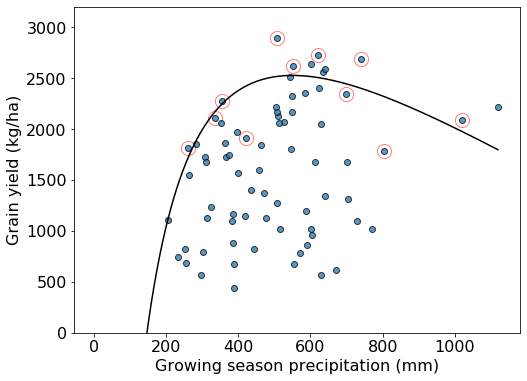

In [42]:
# Plot the data and frontier
plt.figure(figsize=(8,6))
plt.scatter(frontier_rainfall_obs, frontier_yield_obs, s=200, alpha=0.5, facecolor='w', color='r', linewidths=1)
plt.scatter(data["rainfall"], data["grain_yield"], edgecolor='k', alpha=0.75)
plt.plot(frontier_rainfall_line, frontier_yield_line, '-k')
plt.xlabel('Growing season precipitation (mm)', size=16)
plt.ylabel('Grain yield (kg/ha)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,3200)
plt.show()


## Curve interpretation

- The part of the frontier intercepting the `y axis` is negative. We restricted the plot to plausible yield values, which are certainly greater than zero.

- The part of the frontier that intercepts the `x axis` represents the amount of growing season water supply that genertes zero yield. This can be viewed as an inefficiency of the system and represents the minimum water losses (due to runoff, evaporation, drainage, canopy interception, etc.).

- The highest point of the curve gives us an idea of the growing season rainfall required to achieve the highest yeilds. Note that during many years yields in the central range can be much lower than the highest yield. To a great extent this associated to other factors, such as the distribution of the rainfall during the growing season or the occurrence of other factors like heat stress, hail damage, or yield losses due to diseases and pests.

- The last, and decaying, portion of the curve could be due to two main reasons: 1) There is insuficient yield data for years with high growing season rainfall. The chances of receiving two or three times as much rainfall than the median rainfall in a single growing season are probably not very high. 2) Excess of water can be detrimental to the production of grain yield. This actually makes sense and can be related to flooding events, plant lodging, increased disease pressure, weaker root anchoring, and even larger number of cloudy days that reduce the amount of solar radiation for photosynthesis. We don't know the answer from this dataset.

To complete the analysis we will compute few extra metrics that might be useful to summarize the dataset. I assume most of you are familiar with the concept of median (i.e. 50th percentile), which is auseful metric of central tendency robust to outliers and skewed distributions. Perhaps, the most challenging step is the one regarding the searching of the function roots. We can use the Newton-Raphson method (also known as the secant method) for finding function roots (i.e. at what value(s) of x the function f(x) intersects the x-axis). Based on a visual inspection of the graph, we will pass an initial guess for the serach of 200 mm. If you want to learn more about this function you can read the official [SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.newton.html).

We can also estimate the ideal rainfall by finding the point at which the frontier does not show any additional increase in yield with increasing rainfall. We can find this optimum point by finding the point at which the first derivative of the frontier function is zero.


## Additional summary metrics

In [43]:
# Median rainfall
median_rainfall = np.median(data.rainfall)
print(median_rainfall, 'mm')

# Median grain yield
median_yield = np.median(data.grain_yield)
print(median_yield, 'kg/ha')

# Estimate minimum_losses using the Newton-Raphson method
minimum_losses = newton(cobb_douglas, 200, args=par[0])
print('Minimum losses: ', round(minimum_losses), 'mm')

# Optimal rainfall (system input) and grain yield (system output)
# We will approaximate the first derivative using the set of points (i.e. numerical approx.)
# Step 1: Calcualte derivative, Step 2: Calculate absolute value, Step 3: find minimum value
first_diff_approax = np.diff(frontier_yield_line)
idx_zero_diff = np.argmin(np.abs(first_diff_approax))
optimal_rainfall = frontier_rainfall_line[idx_zero_diff]
optimal_yield = frontier_yield_line[idx_zero_diff]
print('Optimal rainfall:', round(optimal_rainfall), 'mm')
print('Optimal yield:', round(optimal_yield), 'kg/ha')


508.254 mm
1680.25698 kg/ha
Minimum losses:  147.0 mm
Optimal rainfall: 550.0 mm
Optimal yield: 2525.0 kg/ha


## Quantile regression

In the previous line of reasoning we have focused on selecting the highest yield within a given rainfall interval. This approach makes direct use of both rainfall and yield observations to build the frontier production function.

An alternative approach is to calculate some statistical variables for each interval. A commonly used technique is that of selecting percentiles or quantiles. You probably heard the term "Quantile regression analysis". I'm sure that `Python` and `R` packages have some advanced features, but here I want show the concept behind the technique, which is similar to the approach described earlier.

For each bin we will simply calculate the yield 95th percentile and the average rainfall. The pairwise points will not necessarily match observations and will likely be smoother since we are filtering out some of the noise.


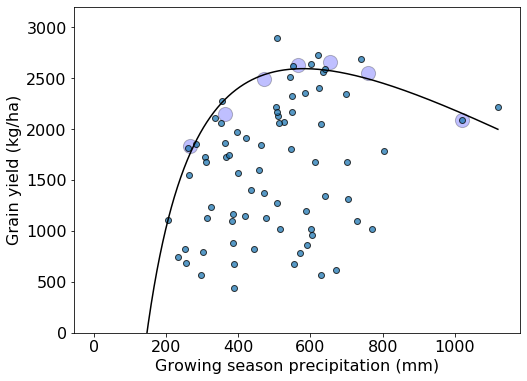

In [52]:
# Quantile regression
max_rainfall = np.max(data.rainfall)
min_rainfall = np.min(data.rainfall)
N = 10 # Number of bins
rainfall_bins = np.linspace(min_rainfall, max_rainfall, N)

frontier_yield_obs = np.array([])
frontier_rainfall_obs = np.array([])

for n in range(0,len(rainfall_bins)-1):
    idx = (data.rainfall >= rainfall_bins[n]) & (data.rainfall < rainfall_bins[n+1])
    
    if np.all(idx == False):
        continue
        
    else:
        rainfall_bin = data.loc[idx, 'rainfall']
        yield_bin = data.loc[idx, 'grain_yield']        

        frontier_rainfall_obs = np.append(frontier_rainfall_obs, np.mean(rainfall_bin))
        frontier_yield_obs = np.append(frontier_yield_obs, np.percentile(yield_bin, 95))

par0 = [1,1,1]

par = curve_fit(cobb_douglas, frontier_rainfall_obs, frontier_yield_obs, par0)

frontier_rainfall_line = np.arange(0,max_rainfall)
frontier_yield_line = cobb_douglas(frontier_rainfall_line, *par[0])


# Plot the data and frontier
plt.figure(figsize=(8,6))
plt.scatter(frontier_rainfall_obs, frontier_yield_obs, 
            s=200, alpha=0.25, facecolor='b', edgecolors='k', linewidths=1)
plt.scatter(data["rainfall"], data["grain_yield"], edgecolor='k', alpha=0.75)
plt.plot(frontier_rainfall_line, frontier_yield_line, '-k')
plt.xlabel('Growing season precipitation (mm)', size=16)
plt.ylabel('Grain yield (kg/ha)', size=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,3200)
plt.show()


In [15]:
# Estimate minimum_losses using the Newton-Raphson method
minimum_losses = newton(cobb_douglas, 200, args=par[0])
print('Minimum losses: ', round(minimum_losses), 'mm')

# Optimal rainfall (system input) and grain yield (system output)
# We will approaximate the first derivative using the set of points (i.e. numerical approx.)
# Step 1: Calcualte derivative, Step 2: Calculate absolute value, Step 3: find minimum value
first_diff_approax = np.diff(frontier_yield_line)
idx_zero_diff = np.argmin(np.abs(first_diff_approax))
optimal_rainfall = frontier_rainfall_line[idx_zero_diff]
optimal_yield = frontier_yield_line[idx_zero_diff]
print('Optimal rainfall:', round(optimal_rainfall), 'mm')
print('Optimal yield:', round(optimal_yield), 'kg/ha')


Minimum losses:  147.0 mm
Optimal rainfall: 580.0 mm
Optimal yield: 2592.0 kg/ha


## Observations

Depending on the method we obtained somewhat different values of minimum losses, optimal rainfall, and optimal yield. So here are some questions for you to think:

- As a researcher how do we determine the right method to analyze our data? Particularly when methods result in slightly different answers.

- Run the code again using a different number of bins. How different are the values for minimum losses and optimum rainfall amounts?

- Should we consider an asymptotic model or a model like the Cobb-Douglas that may exhibit a decreasing trend at high growing season rainfall amounts?


## References

Cobb, C.W. and Douglas, P.H., 1928. A theory of production. The American Economic Review, 18(1), pp.139-165.

French, R.J. and Schultz, J.E., 1984. Water use efficiency of wheat in a Mediterranean-type environment. I. The relation between yield, water use and climate. Australian Journal of Agricultural Research, 35(6), pp.743-764.

Grassini, P., Yang, H. and Cassman, K.G., 2009. Limits to maize productivity in Western Corn-Belt: a simulation analysis for fully irrigated and rainfed conditions. Agricultural and forest meteorology, 149(8), pp.1254-1265.

Patrignani, A., Lollato, R.P., Ochsner, T.E., Godsey, C.B. and Edwards, J., 2014. Yield gap and production gap of rainfed winter wheat in the southern Great Plains. Agronomy Journal, 106(4), pp.1329-1339.

